# NLMFE in practice

This notebook aims at introducing the nlmfe package implementing the FPMLE and FPMLE$^{++}$ algorithms developed in Mugnier and Wang (2022, WP).

In [1]:
from nlmfe.TwoWayFPMLE import TwoWayFPMLE
from nlmfe.BiasCorrections import BiasCorrections
#help(TwoWayFPMLE)

## Simulated example

In [2]:
import numpy as np

def logit_cdf(x):
    """
    logit_cdf:
        evaluate the logistic cumulative distribution function (cdf) at point x.
        
    :param x: evaluation point
    """
    return 1. / (1. + np.exp(-x))

def logit_pdf(x):
    """
    logit_pdf:
        evaluate the logistic probability density function (pdf) at point x.
        
    :param x: evaluation point
    """
    return np.exp(x) / (1. + np.exp(x))**2

We simulate a simple binary logit model 500 times:  $y_{it} \in \{0,1\}$ and for all $i\in\{1,...,N\}, t\in\{1,...,T\}$:

\begin{equation}
Pr(y_{it} =1|x_{it}, \alpha_i, \xi_t) = \frac{1}{1+\exp(-(x_{it}\beta + \alpha_i + \xi_t))}
\end{equation}

with $\beta=1$, $\alpha_1=0$, $\alpha_i \overset{iid}{\sim}\mathcal N(0,1/16)$ for $i\geq 2$, $\xi_t \overset{iid}{\sim}\mathcal N(0,1/16)$, and $x_{it} = v_{it} + \alpha_i$, $v_{it}\overset{iid}{\sim}$Unif$[-\sqrt{3},\sqrt{3}]$. The $\alpha_i, \xi_t,v_{it}$ are mutually independent. We set $N,T=200$.

In [3]:
from tqdm import tqdm
seed = 2022
np.random.seed(seed)

B = 500
n, T = 200, 200
beta = np.ones(1)
alpha = np.random.normal(0, 1/4, size=(B,n)) # indiv FEs
alpha[:,0] = 0 # normalization 
xi = np.random.normal(0, 1/4, size=(B,T)) # time FEs
X = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(B,n,T,len(beta))) + alpha[:,:,None,None]  # correlated effect
M = X.dot(beta) + alpha[:,:,None] + xi[:,None,:]
Y = (np.random.uniform(size=(B,n,T)) <= logit_cdf(M)).astype(int)
ape = beta*np.mean(logit_pdf(M), axis=(1,2))   

We estimate the homogeneous slope coefficient ($\beta$), individual-specific effects ($\alpha_i$) and time-specific effects ($\xi_t$) with FPMLE++.

In [4]:
res_bet = np.empty((B,1))
res_alpha = np.empty((B,n-1))
res_xi = np.empty((B,T))
res_ape = np.empty((B,1))

for b in tqdm(range(B)):
    logit_model = TwoWayFPMLE(X[b], Y[b], model='logit', verbose=False)
    res_bet[b], res_alpha[b], res_xi[b] = logit_model.fit(fast=True, hess=True, iter_max=20) # set fast=False to use FPMLE
    res_ape[b] = res_bet[b]*np.mean(logit_pdf(X[b].dot(res_bet[b]) + np.insert(res_alpha[b], 0, 0)[:,None] + res_xi[b][None,:]))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:13<00:00,  3.75it/s]


In [5]:
print('True beta: ', beta[0])
print('Average bias beta_hat: ', np.mean(res_bet-beta))
print('Average RMSE beta_hat: ', np.mean(np.abs(res_bet-beta)))
print('Average true average partial effect (APE): ', np.mean(ape))
print('Average bias APE_hat: ', np.mean(res_ape-ape))
print('Average RMSE APE_hat: ', np.mean(np.abs(res_ape-ape)))

True beta:  1.0
Average bias beta_hat:  0.01089944132029768
Average RMSE beta_hat:  0.013489840646692022
Average true average partial effect (APE):  0.19419937001920265
Average bias APE_hat:  8.863246923629027e-05
Average RMSE APE_hat:  0.0014495456794012904


In [6]:
# compute analytically bias corrected estimates and standard errors (see Fernandez-Val and Weidner, 2016)
res_bet_BC = np.empty((B, 3))
res_avar_BC = np.empty((B, 3))

for b in tqdm(range(B)):
    biascorrect = BiasCorrections(X[b], Y[b], model='logit')
    res_bet_BC[b,0], res_avar_BC[b,0] = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=0)
    res_bet_BC[b,1], res_avar_BC[b,1] = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=1)
    res_bet_BC[b,2], res_avar_BC[b,2] = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=2)

 37%|█████████████████████████████▉                                                  | 187/500 [00:25<00:42,  7.35it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:11<00:00,  7.00it/s]


In [7]:
# compare bias, RMSE, and coverage of analytical 95% CI 
import pandas as pd
from scipy.stats import norm

table = np.empty((5, 3))
table[:] = np.nan
table[0, 0] = np.nanmean(res_bet-beta)
table[1, 0] = np.nanmean(res_ape-ape)
table[2, 0] = np.nanmean(res_bet_BC[:,0]-beta)
table[3, 0] = np.nanmean(res_bet_BC[:,1]-beta)
table[4, 0] = np.nanmean(res_bet_BC[:,2]-beta)

table[0, 1] = np.nanmean(np.abs(res_bet-beta))
table[1, 1] = np.nanmean(np.abs(res_ape-ape))
table[2, 1] = np.nanmean(np.abs(res_bet_BC[:,0]-beta))
table[3, 1] = np.nanmean(np.abs(res_bet_BC[:,1]-beta))
table[4, 1] = np.nanmean(np.abs(res_bet_BC[:,2]-beta))

table[1, 2] = np.mean((np.abs(res_bet_BC[:,0]-beta) / np.sqrt(res_avar_BC[b,0]/(n*T)) <= norm.ppf(1-0.05/2)))
table[2, 2] = np.mean((np.abs(res_bet_BC[:,1]-beta) / np.sqrt(res_avar_BC[b,1]/(n*T)) <= norm.ppf(1-0.05/2)))
table[3, 2] = np.mean((np.abs(res_bet_BC[:,2]-beta) / np.sqrt(res_avar_BC[b,2]/(n*T)) <= norm.ppf(1-0.05/2)))

res = pd.DataFrame(table)
res.columns = ['Bias', 'RMSE', 'Coverage (.95)']
res.index = ['beta', 'average partial effect (APE)', 'beta_corrected (L=0)', 'beta_corrected (L=1)', 'beta_corrected (L=2)']

print(res)
print(' ')
print('True beta: ', beta[0])
print('Average true APE: ', np.mean(ape))

                                  Bias      RMSE  Coverage (.95)
beta                          0.010899  0.013490             NaN
average partial effect (APE)  0.000089  0.001450           0.580
beta_corrected (L=0)          0.021506  0.021956           0.578
beta_corrected (L=1)          0.021506  0.021956           0.580
beta_corrected (L=2)          0.021504  0.021956             NaN
 
True beta:  1.0
Average true APE:  0.19419937001920265


## Application to real data (selection into international trade)
Helpman et al. (2008) estimate trade flows and explicitly take into account firm selection into export markets. Their method features a first step that estimates the establishment of exportation from one country to another using a binary model. Because of this step, they can then control for the fraction of firms that export (consistently estimated from the first step) and the selection effect due to zero trade flows when estimating the gravity equation in the second step. In the empirical application, this first step is implemented as following (see their equation 12 on page 455):

\begin{equation}
	\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi\left(-\gamma\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j\right), i,j=1,...,N, i \neq j, \qquad (1)
\end{equation}

where $T_{ij}=1$ when country $j$ exports to $i$ and zero otherwise, $\text{dist}_{ij}$ is the distance between $i$ and $j$, $\phi_{ij}$ is a vector of observed country-pair specific variables, $\zeta_i$ ($\xi_j$) is an importer (exporter) fixed effect, and $\Phi$ is the standard normal cumulative distribution function. According to their theoretical model,  $\gamma$ is interpreted as a constant elasticity of a firm's trade with respect to distance. 


Different from the original setting, we allow  $\gamma$ to be country- and exporter-specific:

\begin{equation}
	\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi(-\gamma^{\text{exp}}_j\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j), i,j=1,...,N, i \neq j. \qquad (2)
\end{equation}

Recent literature on international trade raises concerns about the assumption of constant trade elasticities that impose homogeneous effects of trade cost shifters (see Carrère et al. (2020); Chen and Novy (2021) for examples). The specification in (2) relaxes this assumption along two dimensions. First, it  allows firms from different countries to react differently to the same change in trade cost shifters when exporting to the same third country. Second, two countries in a trade relationship, when exporting to the other, can react differently to the same change in the trade cost shifters that affects the trade in both directions. Furthermore, this specification is implied by a theoretical model along the lines of Helpman et al. (2008) with demand elasticity in the product market being  country-specific. *[Concretely, denote by $\varepsilon_j$ the demand elasticity in country $j$ in their equation 2 on page 449. Then, the log of trade cost,* $\ln \tau_{ij}$*, enters the first (and the second) step with a coefficient $\varepsilon_j-1$. As a result, along the lines of their empirical specification, we can specify* $(\varepsilon_j-1)\ln\tau_{ij}=\gamma_j^{\text{exp}}d_{ij}-u_{ij}$*.]* 

We also consider another specification that allows   $\gamma$ to be country- and importer-specific:

\begin{equation}
		\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi(-\gamma^{\text{imp}}_i\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j), i,j=1,...,N, i \neq j. \qquad (3)
\end{equation}

Similar to (2), the specification in (3) allows two countries in a trade relationship to react differently to the same change in the trade cost shifters that affects the trade in both directions. Moreover, (3) can also incorporate firm's heterogeneous reaction to the same change in trade cost shifters, depending on the country it exports to.  

In what follows, we estimate the first step of the method by Helpman et al. (2008) using  (2) and (3), and quantify the extent to which the trade elasticity is heterogeneous among countries.

### Data

In [8]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [9]:
import wget
import zipfile as zf

# import Helpman et al. (2008) data
url = 'https://scholar.harvard.edu/files/melitz/files/gravity_data_share.zip'
wget.download(url)
files = zf.ZipFile('gravity_data_share.zip','r')
files.extractall()
files.close()

100% [..........................................................................] 1532500 / 1532500

In [10]:
# read data
data = pd.read_stata('data1980s_share.dta', convert_dates=False, convert_categoricals=False, preserve_dtypes=True)

# keep if year==1986
data = data[data['year']==1986]

# drop CONGO as exporter because it did not export to any country in 1986
data = data[data['expcode']!=141780]

# create trade dummy 
data['trade'] = (data['ln_trade'].isna()==False).astype(float) 

data.head()

,year,expcode,impcode,common_lang,legalsystem_same,religion_same,religion_same_recoded,border,cu,ln_distance,fta,ln_trade,colonial,gatt_wto,n_islands,n_landlock,trade
5,1986,117100,130120,0,0,0.013403,0.013403,0,0,4.106691,0,6.761573,0,1,0,0,1.0
17,1986,117100,134340,1,0,0.012962,0.013351,0,0,3.997316,0,NaN,0,1,0,0,0.0
22,1986,117100,135040,0,0,0.013130,0.013130,0,0,4.212758,0,8.024535,0,1,0,0,1.0
30,1986,117100,137320,0,0,0.013000,0.013000,0,0,3.991379,0,NaN,0,1,0,0,0.0
49,1986,117100,137360,1,1,0.014067,0.014456,0,0,3.793402,0,NaN,0,1,0,0,0.0


In [11]:
print(len(np.unique(data['expcode'])))
print(len(np.unique(data['impcode'])))

157
158


### Estimate exporter-specific effects

In [12]:
# sort columns and convert data to numeric
data = data[['expcode', 'impcode', 'ln_distance', 'border', 'n_islands', 'n_landlock', 'legalsystem_same','common_lang', 
             'colonial', 'cu', 'fta', 'religion_same', 'trade']]
for j in data.columns[2:]:
    data[j] = pd.to_numeric(data[j])

# nlmfe need some preprocessing of the data into N x T x K panel structure
from nlmfe.PanelPreProcess import PanelPreProcess
PanelPreProcess = PanelPreProcess()
data = data.sort_values(['expcode', 'impcode'])
Xexp, yexp, exp_ids, _ = PanelPreProcess.reshape_MaR(np.array(data)[:,:-1],  np.array(data)[:,-1], 0, 1)

In [13]:
# estimate exporter-specific distance effects 
# normalize exporter fixed effect by first alphabetic country: AFGHANISTAN  (see https://www23.statcan.gc.ca/imdb-bmdi/pub/document/2201_DLI_D7_T22_V1-fra.pdf)
AFG = np.where(exp_ids==450040)[0]

probit_model = TwoWayFPMLE(Xexp, yexp, indiv_ref=AFG, het_exog=[0], model='probit')
beta_exp, alpha_exp, xi_exp = probit_model.fit(fast=True, hess=True, iter_max=2)
marginal_effect_at_mean_exp = np.mean(beta_exp[:,0])*norm.pdf(np.nanmean(np.einsum('ijk,ik->ij', Xexp, beta_exp) 
                + np.insert(alpha_exp, AFG, 0)[:,None] + xi_exp[None,:]))
average_partial_effect_exp = np.nanmean(beta_exp[:,0].reshape(len(exp_ids))[:,None]*norm.pdf(
                np.einsum('ijk,ik->ij', Xexp, beta_exp)  + np.insert(alpha_exp, AFG, 0)[:,None] + xi_exp[None,:]))

Mixed heterogeneous and homogeneous slopes model.


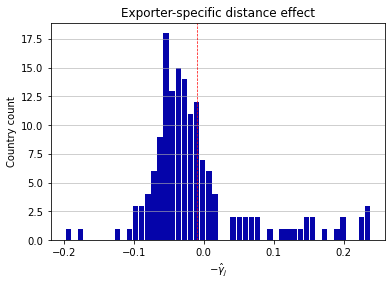

In [14]:
# histogram of heterogeneous effects
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (6,4))
plt.axvline(x=np.mean(beta_exp[:,0]), color='red', linestyle='--', linewidth=0.7)
plt.hist(beta_exp[:,0], bins=50, rwidth=0.9, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Country count')
plt.xlabel(r'$-\hat \gamma_{j}$')
plt.title('Exporter-specific distance effect')
plt.show()

In [15]:
print(np.round([np.mean(beta_exp[:,0]), marginal_effect_at_mean_exp, average_partial_effect_exp], 4))

[-0.0096 -0.0038 -0.0048]


*Note that these results do not exactly match that in the paper probably because of Jupyter's notebook rounding errors*.

### Estimate importer-specific effects

In [16]:
# estimate importer-specific distance effects 
from nlmfe.PanelPreProcess import PanelPreProcess
PanelPreProcess = PanelPreProcess()
data = data.sort_values(['impcode', 'expcode'])
Ximp, yimp, imp_ids, _ = PanelPreProcess.reshape_MaR(np.array(data)[:,:-1], np.array(data)[:,-1], 1, 0)

prob_mod = TwoWayFPMLE(Ximp, yimp, AFG, [0], model='probit')
beta_imp, alpha_imp, xi_imp = prob_mod.fit(fast=True, hess=True, iter_max=2)
marginal_effect_at_mean_imp = np.mean(beta_imp[:,0])*norm.pdf(np.nanmean(np.einsum('ijk,ik->ij', Ximp, beta_imp) 
                                + np.insert(alpha_imp, AFG, 0)[:,None] + xi_imp[None,:]))
average_partial_effect_imp = np.nanmean(beta_imp[:,0].reshape(len(imp_ids))[:,None]*norm.pdf(np.einsum('ijk,ik->ij', 
                                Ximp, beta_imp) + np.insert(alpha_imp, AFG, 0)[:,None] + xi_imp[None,:]))

Mixed heterogeneous and homogeneous slopes model.


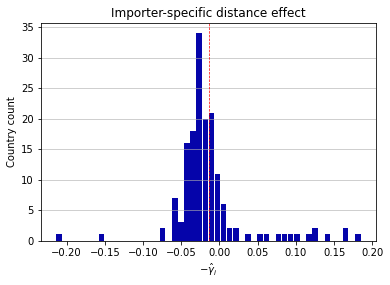

In [17]:
# histogram of heterogeneous effects
fig, ax = plt.subplots(figsize = (6,4))
plt.axvline(x=np.mean(beta_imp[:,0]), color='red', linestyle='--', linewidth=0.7)
plt.hist(beta_imp[:,0], bins=50, rwidth=0.9, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Country count')
plt.xlabel(r'$-\hat \gamma_{i}$')
plt.title('Importer-specific distance effect')
plt.show()

In [18]:
print(np.mean(beta_imp[:,0]))
print(marginal_effect_at_mean_imp)
print(average_partial_effect_imp)

-0.014346214817769576
-0.005708598291670141
-0.003932018561511836


*Again, these results do not match exactly that in the paper probably because of Jupyter's rounding errors.*

### Percentile bootstrap (symmetric) CIs for standard deviation

In [19]:
# compute percentile bootstrap (symmetric) CIs for standard deviation 
np.random.seed(2022) # replicability
B = 500
bs_samples_exp = np.random.choice(range(len(exp_ids)), size=(B, len(exp_ids)))
bs_samples_imp = np.random.choice(range(len(imp_ids)), size=(B, len(imp_ids)))
beta_res_exp = np.zeros((B, len(exp_ids), 1))
beta_res_imp = np.zeros((B, len(imp_ids), 1))

for b in tqdm(range(B)):
    prob_mod_exp = TwoWayFPMLE(Xexp[bs_samples_exp[b]], yexp[bs_samples_exp[b]], 0, [0], model='probit', verbose=False)
    beta_exp, _, _ = prob_mod_exp.fit(fast=True, hess=True, nu=1e-9, eps=1e-4, iter_max=2)
    beta_res_exp[b,:, 0] = beta_exp[:,0]
    prob_mod_imp = TwoWayFPMLE(Ximp[bs_samples_imp[b]], yimp[bs_samples_imp[b]], 0, [0], model='probit', verbose=False)
    beta_imp, _, _ = prob_mod_imp.fit(fast=True, hess=True, nu=1e-9, eps=1e-4, iter_max=2)
    beta_res_imp[b,:, 0] = beta_imp[:,0]

bs_std_exp = np.std(beta_res_exp, axis=1)
bs_std_imp = np.std(beta_res_imp, axis=1)
bs_std = np.concatenate((bs_std_exp, bs_std_imp), axis=1)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/500 [00:00<02:08,  3.89it/s]

  0%|▎                                                                                 | 2/500 [00:00<02:06,  3.95it/s]

  1%|▍                                                                                 | 3/500 [00:00<02:08,  3.86it/s]

  1%|▋                                                                                 | 4/500 [00:01<02:08,  3.85it/s]

  1%|▊                                                                                 | 5/500 [00:01<02:09,  3.82it/s]

  1%|▉                                                                                 | 6/500 [00:01<02:13,  3.71it/s]

  1%|█▏                                                                                | 7/500 [00:01<02:18,  3.55it/s]

  2%|█▎                                                                                | 8/500 [00:02<02:21,  3.47it/s]

  2%|█▍                                                                                | 9/500 [00:02<02:23,  3.43it/s]

  2%|█▌                                                                               | 10/500 [00:02<02:22,  3.44it/s]

  2%|█▊                                                                               | 11/500 [00:03<02:22,  3.43it/s]

  2%|█▉                                                                               | 12/500 [00:03<02:21,  3.45it/s]

  3%|██                                                                               | 13/500 [00:03<02:22,  3.43it/s]

  3%|██▎                                                                              | 14/500 [00:03<02:22,  3.41it/s]

  3%|██▍                                                                              | 15/500 [00:04<02:22,  3.41it/s]C:\Users\MartinMUGNIER\Documents\packages\nlmfe\func.py:460: RuntimeWarning: divide by zero encountered in true_divide
  hess = A[:,:,:,None]*A[:,:,None,:] * (m**2/ (M*(1-M)))[:,:, None, None]
C:\Users\MartinMUGNIER\Documents\packages\nlmfe\func.py:460: RuntimeWarning: invalid value encountered in multiply
  hess = A[:,:,:,None]*A[:,:,None,:] * (m**2/ (M*(1-M)))[:,:, None, None]
C:\Users\MartinMUGNIER\Documents\packages\nlmfe\func.py:260: RuntimeWarning: divide by zero encountered in true_divide
  grad = np.nansum(A * ((m/(M*(1-M))) * (b-M))[:,:,None], axis)
C:\Users\MartinMUGNIER\Documents\packages\nlmfe\func.py:260: RuntimeWarning: invalid value encountered in multiply
  grad = np.nansum(A * ((m/(M*(1-M))) * (b-M))[:,:,None], axis)


  3%|██▌                                                                              | 16/500 [00:04<02:23,  3.37it/s]

  3%|██▊                                                                              | 17/500 [00:04<02:23,  3.36it/s]

  4%|██▉                                                                              | 18/500 [00:05<02:24,  3.33it/s]

  4%|███                                                                              | 19/500 [00:05<02:27,  3.27it/s]

  4%|███▏                                                                             | 20/500 [00:05<02:25,  3.30it/s]

  4%|███▍                                                                             | 21/500 [00:06<02:24,  3.31it/s]

  4%|███▌                                                                             | 22/500 [00:06<02:24,  3.32it/s]

  5%|███▋                                                                             | 23/500 [00:06<02:24,  3.30it/s]

  5%|███▉                                                                             | 24/500 [00:06<02:25,  3.28it/s]

  5%|████                                                                             | 25/500 [00:07<02:23,  3.32it/s]

  5%|████▏                                                                            | 26/500 [00:07<02:24,  3.29it/s]

  5%|████▎                                                                            | 27/500 [00:07<02:22,  3.33it/s]

  6%|████▌                                                                            | 28/500 [00:08<02:20,  3.35it/s]

  6%|████▋                                                                            | 29/500 [00:08<02:23,  3.27it/s]

  6%|████▊                                                                            | 30/500 [00:08<02:25,  3.24it/s]

  6%|█████                                                                            | 31/500 [00:09<02:22,  3.29it/s]

  6%|█████▏                                                                           | 32/500 [00:09<02:21,  3.31it/s]

  7%|█████▎                                                                           | 33/500 [00:09<02:19,  3.34it/s]

  7%|█████▌                                                                           | 34/500 [00:09<02:18,  3.36it/s]

  7%|█████▋                                                                           | 35/500 [00:10<02:19,  3.33it/s]

  7%|█████▊                                                                           | 36/500 [00:10<02:21,  3.28it/s]

  7%|█████▉                                                                           | 37/500 [00:10<02:21,  3.27it/s]

  8%|██████▏                                                                          | 38/500 [00:11<02:22,  3.23it/s]

  8%|██████▎                                                                          | 39/500 [00:11<02:21,  3.25it/s]

  8%|██████▍                                                                          | 40/500 [00:11<02:21,  3.25it/s]

  8%|██████▋                                                                          | 41/500 [00:12<02:20,  3.27it/s]

  8%|██████▊                                                                          | 42/500 [00:12<02:20,  3.25it/s]

  9%|██████▉                                                                          | 43/500 [00:12<02:21,  3.24it/s]

  9%|███████▏                                                                         | 44/500 [00:13<02:21,  3.22it/s]

  9%|███████▎                                                                         | 45/500 [00:13<02:17,  3.30it/s]

  9%|███████▍                                                                         | 46/500 [00:13<02:20,  3.23it/s]

  9%|███████▌                                                                         | 47/500 [00:14<02:19,  3.25it/s]

 10%|███████▊                                                                         | 48/500 [00:14<02:19,  3.24it/s]

 10%|███████▉                                                                         | 49/500 [00:14<02:22,  3.18it/s]

 10%|████████                                                                         | 50/500 [00:14<02:21,  3.18it/s]

 10%|████████▎                                                                        | 51/500 [00:15<02:19,  3.21it/s]

 10%|████████▍                                                                        | 52/500 [00:15<02:18,  3.24it/s]

 11%|████████▌                                                                        | 53/500 [00:15<02:18,  3.23it/s]

 11%|████████▋                                                                        | 54/500 [00:16<02:15,  3.30it/s]

 11%|████████▉                                                                        | 55/500 [00:16<02:13,  3.33it/s]

 11%|█████████                                                                        | 56/500 [00:16<02:15,  3.28it/s]

 11%|█████████▏                                                                       | 57/500 [00:17<02:16,  3.24it/s]

 12%|█████████▍                                                                       | 58/500 [00:17<02:18,  3.18it/s]

 12%|█████████▌                                                                       | 59/500 [00:17<02:19,  3.15it/s]

 12%|█████████▋                                                                       | 60/500 [00:18<02:21,  3.11it/s]

 12%|█████████▉                                                                       | 61/500 [00:18<02:19,  3.16it/s]

 12%|██████████                                                                       | 62/500 [00:18<02:18,  3.16it/s]

 13%|██████████▏                                                                      | 63/500 [00:19<02:18,  3.16it/s]

 13%|██████████▎                                                                      | 64/500 [00:19<02:16,  3.19it/s]

 13%|██████████▌                                                                      | 65/500 [00:19<02:14,  3.23it/s]

 13%|██████████▋                                                                      | 66/500 [00:19<02:13,  3.26it/s]

 13%|██████████▊                                                                      | 67/500 [00:20<02:12,  3.26it/s]

 14%|███████████                                                                      | 68/500 [00:20<02:12,  3.26it/s]

 14%|███████████▏                                                                     | 69/500 [00:20<02:13,  3.24it/s]

 14%|███████████▎                                                                     | 70/500 [00:21<02:13,  3.22it/s]

 14%|███████████▌                                                                     | 71/500 [00:21<02:12,  3.24it/s]

 14%|███████████▋                                                                     | 72/500 [00:21<02:13,  3.20it/s]

 15%|███████████▊                                                                     | 73/500 [00:22<02:14,  3.17it/s]

 15%|███████████▉                                                                     | 74/500 [00:22<02:11,  3.24it/s]

 15%|████████████▏                                                                    | 75/500 [00:22<02:11,  3.24it/s]

 15%|████████████▎                                                                    | 76/500 [00:23<02:11,  3.23it/s]

 15%|████████████▍                                                                    | 77/500 [00:23<02:11,  3.22it/s]

 16%|████████████▋                                                                    | 78/500 [00:23<02:11,  3.21it/s]

 16%|████████████▊                                                                    | 79/500 [00:23<02:11,  3.21it/s]

 16%|████████████▉                                                                    | 80/500 [00:24<02:11,  3.19it/s]

 16%|█████████████                                                                    | 81/500 [00:24<02:09,  3.22it/s]

 16%|█████████████▎                                                                   | 82/500 [00:24<02:09,  3.23it/s]

 17%|█████████████▍                                                                   | 83/500 [00:25<02:08,  3.24it/s]

 17%|█████████████▌                                                                   | 84/500 [00:25<02:07,  3.25it/s]

 17%|█████████████▊                                                                   | 85/500 [00:25<02:06,  3.27it/s]

 17%|█████████████▉                                                                   | 86/500 [00:26<02:05,  3.30it/s]

 17%|██████████████                                                                   | 87/500 [00:26<02:08,  3.22it/s]

 18%|██████████████▎                                                                  | 88/500 [00:26<02:10,  3.16it/s]

 18%|██████████████▍                                                                  | 89/500 [00:27<02:10,  3.15it/s]

 18%|██████████████▌                                                                  | 90/500 [00:27<02:08,  3.18it/s]

 18%|██████████████▋                                                                  | 91/500 [00:27<02:05,  3.25it/s]

 18%|██████████████▉                                                                  | 92/500 [00:27<02:04,  3.28it/s]

 19%|███████████████                                                                  | 93/500 [00:28<02:02,  3.34it/s]

 19%|███████████████▏                                                                 | 94/500 [00:28<02:02,  3.32it/s]

 19%|███████████████▍                                                                 | 95/500 [00:28<02:02,  3.29it/s]

 19%|███████████████▌                                                                 | 96/500 [00:29<02:03,  3.28it/s]

 19%|███████████████▋                                                                 | 97/500 [00:29<02:01,  3.32it/s]

 20%|███████████████▉                                                                 | 98/500 [00:29<02:00,  3.33it/s]

 20%|████████████████                                                                 | 99/500 [00:30<01:59,  3.35it/s]

 20%|████████████████                                                                | 100/500 [00:30<01:57,  3.40it/s]

 20%|████████████████▏                                                               | 101/500 [00:30<02:00,  3.32it/s]

 20%|████████████████▎                                                               | 102/500 [00:30<01:59,  3.32it/s]

 21%|████████████████▍                                                               | 103/500 [00:31<01:59,  3.33it/s]

 21%|████████████████▋                                                               | 104/500 [00:31<01:57,  3.36it/s]

 21%|████████████████▊                                                               | 105/500 [00:31<01:55,  3.41it/s]

 21%|████████████████▉                                                               | 106/500 [00:32<01:55,  3.41it/s]

 21%|█████████████████                                                               | 107/500 [00:32<01:54,  3.42it/s]

 22%|█████████████████▎                                                              | 108/500 [00:32<01:56,  3.37it/s]

 22%|█████████████████▍                                                              | 109/500 [00:33<01:57,  3.33it/s]

 22%|█████████████████▌                                                              | 110/500 [00:33<01:56,  3.34it/s]

 22%|█████████████████▊                                                              | 111/500 [00:33<01:55,  3.36it/s]

 22%|█████████████████▉                                                              | 112/500 [00:33<01:54,  3.38it/s]

 23%|██████████████████                                                              | 113/500 [00:34<01:55,  3.34it/s]

 23%|██████████████████▏                                                             | 114/500 [00:34<01:54,  3.37it/s]

 23%|██████████████████▍                                                             | 115/500 [00:34<01:54,  3.36it/s]

 23%|██████████████████▌                                                             | 116/500 [00:35<01:53,  3.39it/s]

 23%|██████████████████▋                                                             | 117/500 [00:35<01:53,  3.39it/s]

 24%|██████████████████▉                                                             | 118/500 [00:35<01:52,  3.40it/s]

 24%|███████████████████                                                             | 119/500 [00:36<01:53,  3.36it/s]

 24%|███████████████████▏                                                            | 120/500 [00:36<01:53,  3.35it/s]

 24%|███████████████████▎                                                            | 121/500 [00:36<01:53,  3.33it/s]

 24%|███████████████████▌                                                            | 122/500 [00:36<01:52,  3.37it/s]

 25%|███████████████████▋                                                            | 123/500 [00:37<01:52,  3.36it/s]

 25%|███████████████████▊                                                            | 124/500 [00:37<01:51,  3.37it/s]

 25%|████████████████████                                                            | 125/500 [00:37<01:50,  3.38it/s]

 25%|████████████████████▏                                                           | 126/500 [00:38<01:51,  3.37it/s]

 25%|████████████████████▎                                                           | 127/500 [00:38<01:49,  3.42it/s]

 26%|████████████████████▍                                                           | 128/500 [00:38<01:49,  3.40it/s]

 26%|████████████████████▋                                                           | 129/500 [00:38<01:50,  3.35it/s]

 26%|████████████████████▊                                                           | 130/500 [00:39<01:50,  3.34it/s]

 26%|████████████████████▉                                                           | 131/500 [00:39<01:49,  3.37it/s]

 26%|█████████████████████                                                           | 132/500 [00:39<01:50,  3.33it/s]

 27%|█████████████████████▎                                                          | 133/500 [00:40<01:49,  3.35it/s]

 27%|█████████████████████▍                                                          | 134/500 [00:40<01:49,  3.34it/s]

 27%|█████████████████████▌                                                          | 135/500 [00:40<01:52,  3.24it/s]

 27%|█████████████████████▊                                                          | 136/500 [00:41<01:50,  3.28it/s]

 27%|█████████████████████▉                                                          | 137/500 [00:41<01:49,  3.32it/s]

 28%|██████████████████████                                                          | 138/500 [00:41<01:48,  3.34it/s]

 28%|██████████████████████▏                                                         | 139/500 [00:41<01:49,  3.29it/s]

 28%|██████████████████████▍                                                         | 140/500 [00:42<01:47,  3.35it/s]

 28%|██████████████████████▌                                                         | 141/500 [00:42<01:46,  3.38it/s]

 28%|██████████████████████▋                                                         | 142/500 [00:42<01:47,  3.33it/s]

 29%|██████████████████████▉                                                         | 143/500 [00:43<01:46,  3.35it/s]

 29%|███████████████████████                                                         | 144/500 [00:43<01:45,  3.38it/s]

 29%|███████████████████████▏                                                        | 145/500 [00:43<01:45,  3.37it/s]

 29%|███████████████████████▎                                                        | 146/500 [00:44<01:45,  3.36it/s]

 29%|███████████████████████▌                                                        | 147/500 [00:44<01:45,  3.35it/s]

 30%|███████████████████████▋                                                        | 148/500 [00:44<01:44,  3.35it/s]

 30%|███████████████████████▊                                                        | 149/500 [00:44<01:44,  3.37it/s]

 30%|████████████████████████                                                        | 150/500 [00:45<01:43,  3.38it/s]

 30%|████████████████████████▏                                                       | 151/500 [00:45<01:44,  3.36it/s]

 30%|████████████████████████▎                                                       | 152/500 [00:45<01:44,  3.32it/s]

 31%|████████████████████████▍                                                       | 153/500 [00:46<01:43,  3.34it/s]

 31%|████████████████████████▋                                                       | 154/500 [00:46<01:43,  3.34it/s]

 31%|████████████████████████▊                                                       | 155/500 [00:46<01:43,  3.35it/s]

 31%|████████████████████████▉                                                       | 156/500 [00:47<01:42,  3.37it/s]

 31%|█████████████████████████                                                       | 157/500 [00:47<01:42,  3.34it/s]

 32%|█████████████████████████▎                                                      | 158/500 [00:47<01:41,  3.38it/s]

 32%|█████████████████████████▍                                                      | 159/500 [00:47<01:40,  3.39it/s]

 32%|█████████████████████████▌                                                      | 160/500 [00:48<01:40,  3.39it/s]

 32%|█████████████████████████▊                                                      | 161/500 [00:48<01:41,  3.34it/s]

 32%|█████████████████████████▉                                                      | 162/500 [00:48<01:41,  3.32it/s]

 33%|██████████████████████████                                                      | 163/500 [00:49<01:41,  3.33it/s]

 33%|██████████████████████████▏                                                     | 164/500 [00:49<01:40,  3.34it/s]

 33%|██████████████████████████▍                                                     | 165/500 [00:49<01:41,  3.29it/s]

 33%|██████████████████████████▌                                                     | 166/500 [00:50<01:40,  3.33it/s]

 33%|██████████████████████████▋                                                     | 167/500 [00:50<01:38,  3.39it/s]

 34%|██████████████████████████▉                                                     | 168/500 [00:50<01:38,  3.36it/s]

 34%|███████████████████████████                                                     | 169/500 [00:50<01:38,  3.37it/s]

 34%|███████████████████████████▏                                                    | 170/500 [00:51<01:36,  3.42it/s]

 34%|███████████████████████████▎                                                    | 171/500 [00:51<01:36,  3.41it/s]

 34%|███████████████████████████▌                                                    | 172/500 [00:51<01:35,  3.44it/s]

 35%|███████████████████████████▋                                                    | 173/500 [00:52<01:35,  3.43it/s]

 35%|███████████████████████████▊                                                    | 174/500 [00:52<01:36,  3.38it/s]

 35%|████████████████████████████                                                    | 175/500 [00:52<01:36,  3.38it/s]

 35%|████████████████████████████▏                                                   | 176/500 [00:52<01:36,  3.36it/s]

 35%|████████████████████████████▎                                                   | 177/500 [00:53<01:34,  3.40it/s]

 36%|████████████████████████████▍                                                   | 178/500 [00:53<01:35,  3.37it/s]

 36%|████████████████████████████▋                                                   | 179/500 [00:53<01:34,  3.38it/s]

 36%|████████████████████████████▊                                                   | 180/500 [00:54<01:34,  3.38it/s]

 36%|████████████████████████████▉                                                   | 181/500 [00:54<01:34,  3.39it/s]

 36%|█████████████████████████████                                                   | 182/500 [00:54<01:34,  3.36it/s]

 37%|█████████████████████████████▎                                                  | 183/500 [00:55<01:33,  3.38it/s]

 37%|█████████████████████████████▍                                                  | 184/500 [00:55<01:33,  3.39it/s]

 37%|█████████████████████████████▌                                                  | 185/500 [00:55<01:32,  3.41it/s]

 37%|█████████████████████████████▊                                                  | 186/500 [00:55<01:32,  3.40it/s]

 37%|█████████████████████████████▉                                                  | 187/500 [00:56<01:32,  3.38it/s]

 38%|██████████████████████████████                                                  | 188/500 [00:56<01:32,  3.38it/s]

 38%|██████████████████████████████▏                                                 | 189/500 [00:56<01:31,  3.40it/s]

 38%|██████████████████████████████▍                                                 | 190/500 [00:57<01:32,  3.36it/s]

 38%|██████████████████████████████▌                                                 | 191/500 [00:57<01:31,  3.37it/s]

 38%|██████████████████████████████▋                                                 | 192/500 [00:57<01:30,  3.40it/s]

 39%|██████████████████████████████▉                                                 | 193/500 [00:57<01:30,  3.40it/s]

 39%|███████████████████████████████                                                 | 194/500 [00:58<01:29,  3.41it/s]

 39%|███████████████████████████████▏                                                | 195/500 [00:58<01:29,  3.42it/s]

 39%|███████████████████████████████▎                                                | 196/500 [00:58<01:29,  3.39it/s]

 39%|███████████████████████████████▌                                                | 197/500 [00:59<01:28,  3.42it/s]

 40%|███████████████████████████████▋                                                | 198/500 [00:59<01:28,  3.40it/s]

 40%|███████████████████████████████▊                                                | 199/500 [00:59<01:29,  3.35it/s]

 40%|████████████████████████████████                                                | 200/500 [01:00<01:29,  3.35it/s]

 40%|████████████████████████████████▏                                               | 201/500 [01:00<01:28,  3.38it/s]

 40%|████████████████████████████████▎                                               | 202/500 [01:00<01:27,  3.39it/s]

 41%|████████████████████████████████▍                                               | 203/500 [01:00<01:28,  3.35it/s]

 41%|████████████████████████████████▋                                               | 204/500 [01:01<01:27,  3.37it/s]

 41%|████████████████████████████████▊                                               | 205/500 [01:01<01:26,  3.41it/s]

 41%|████████████████████████████████▉                                               | 206/500 [01:01<01:26,  3.40it/s]

 41%|█████████████████████████████████                                               | 207/500 [01:02<01:25,  3.44it/s]

 42%|█████████████████████████████████▎                                              | 208/500 [01:02<01:25,  3.42it/s]

 42%|█████████████████████████████████▍                                              | 209/500 [01:02<01:27,  3.34it/s]

 42%|█████████████████████████████████▌                                              | 210/500 [01:03<01:27,  3.32it/s]

 42%|█████████████████████████████████▊                                              | 211/500 [01:03<01:26,  3.35it/s]

 42%|█████████████████████████████████▉                                              | 212/500 [01:03<01:24,  3.40it/s]

 43%|██████████████████████████████████                                              | 213/500 [01:03<01:23,  3.43it/s]

 43%|██████████████████████████████████▏                                             | 214/500 [01:04<01:23,  3.43it/s]

 43%|██████████████████████████████████▍                                             | 215/500 [01:04<01:23,  3.42it/s]

 43%|██████████████████████████████████▌                                             | 216/500 [01:04<01:23,  3.40it/s]

 43%|██████████████████████████████████▋                                             | 217/500 [01:05<01:23,  3.38it/s]

 44%|██████████████████████████████████▉                                             | 218/500 [01:05<01:23,  3.36it/s]

 44%|███████████████████████████████████                                             | 219/500 [01:05<01:23,  3.37it/s]

 44%|███████████████████████████████████▏                                            | 220/500 [01:05<01:22,  3.38it/s]

 44%|███████████████████████████████████▎                                            | 221/500 [01:06<01:21,  3.42it/s]

 44%|███████████████████████████████████▌                                            | 222/500 [01:06<01:23,  3.35it/s]

 45%|███████████████████████████████████▋                                            | 223/500 [01:06<01:23,  3.32it/s]

 45%|███████████████████████████████████▊                                            | 224/500 [01:07<01:23,  3.30it/s]

 45%|████████████████████████████████████                                            | 225/500 [01:07<01:23,  3.27it/s]

 45%|████████████████████████████████████▏                                           | 226/500 [01:07<01:24,  3.25it/s]

 45%|████████████████████████████████████▎                                           | 227/500 [01:08<01:23,  3.27it/s]

 46%|████████████████████████████████████▍                                           | 228/500 [01:08<01:24,  3.24it/s]

 46%|████████████████████████████████████▋                                           | 229/500 [01:08<01:23,  3.26it/s]

 46%|████████████████████████████████████▊                                           | 230/500 [01:09<01:23,  3.25it/s]

 46%|████████████████████████████████████▉                                           | 231/500 [01:09<01:22,  3.26it/s]

 46%|█████████████████████████████████████                                           | 232/500 [01:09<01:22,  3.26it/s]

 47%|█████████████████████████████████████▎                                          | 233/500 [01:09<01:21,  3.29it/s]

 47%|█████████████████████████████████████▍                                          | 234/500 [01:10<01:20,  3.28it/s]

 47%|█████████████████████████████████████▌                                          | 235/500 [01:10<01:20,  3.31it/s]

 47%|█████████████████████████████████████▊                                          | 236/500 [01:10<01:20,  3.28it/s]

 47%|█████████████████████████████████████▉                                          | 237/500 [01:11<01:19,  3.32it/s]

 48%|██████████████████████████████████████                                          | 238/500 [01:11<01:18,  3.32it/s]

 48%|██████████████████████████████████████▏                                         | 239/500 [01:11<01:18,  3.32it/s]

 48%|██████████████████████████████████████▍                                         | 240/500 [01:12<01:18,  3.30it/s]

 48%|██████████████████████████████████████▌                                         | 241/500 [01:12<01:17,  3.33it/s]

 48%|██████████████████████████████████████▋                                         | 242/500 [01:12<01:17,  3.33it/s]

 49%|██████████████████████████████████████▉                                         | 243/500 [01:12<01:17,  3.30it/s]

 49%|███████████████████████████████████████                                         | 244/500 [01:13<01:17,  3.29it/s]

 49%|███████████████████████████████████████▏                                        | 245/500 [01:13<01:18,  3.25it/s]

 49%|███████████████████████████████████████▎                                        | 246/500 [01:13<01:17,  3.28it/s]

 49%|███████████████████████████████████████▌                                        | 247/500 [01:14<01:17,  3.27it/s]

 50%|███████████████████████████████████████▋                                        | 248/500 [01:14<01:18,  3.22it/s]

 50%|███████████████████████████████████████▊                                        | 249/500 [01:14<01:17,  3.25it/s]

 50%|████████████████████████████████████████                                        | 250/500 [01:15<01:17,  3.24it/s]

 50%|████████████████████████████████████████▏                                       | 251/500 [01:15<01:15,  3.30it/s]

 50%|████████████████████████████████████████▎                                       | 252/500 [01:15<01:14,  3.33it/s]

 51%|████████████████████████████████████████▍                                       | 253/500 [01:16<01:14,  3.33it/s]

 51%|████████████████████████████████████████▋                                       | 254/500 [01:16<01:13,  3.34it/s]

 51%|████████████████████████████████████████▊                                       | 255/500 [01:16<01:13,  3.34it/s]

 51%|████████████████████████████████████████▉                                       | 256/500 [01:16<01:13,  3.31it/s]

 51%|█████████████████████████████████████████                                       | 257/500 [01:17<01:12,  3.34it/s]

 52%|█████████████████████████████████████████▎                                      | 258/500 [01:17<01:12,  3.33it/s]

 52%|█████████████████████████████████████████▍                                      | 259/500 [01:17<01:13,  3.30it/s]

 52%|█████████████████████████████████████████▌                                      | 260/500 [01:18<01:12,  3.31it/s]

 52%|█████████████████████████████████████████▊                                      | 261/500 [01:18<01:12,  3.29it/s]

 52%|█████████████████████████████████████████▉                                      | 262/500 [01:18<01:12,  3.28it/s]

 53%|██████████████████████████████████████████                                      | 263/500 [01:19<01:12,  3.26it/s]

 53%|██████████████████████████████████████████▏                                     | 264/500 [01:19<01:12,  3.27it/s]

 53%|██████████████████████████████████████████▍                                     | 265/500 [01:19<01:11,  3.29it/s]

 53%|██████████████████████████████████████████▌                                     | 266/500 [01:19<01:10,  3.32it/s]

 53%|██████████████████████████████████████████▋                                     | 267/500 [01:20<01:09,  3.34it/s]

 54%|██████████████████████████████████████████▉                                     | 268/500 [01:20<01:09,  3.33it/s]

 54%|███████████████████████████████████████████                                     | 269/500 [01:20<01:09,  3.32it/s]

 54%|███████████████████████████████████████████▏                                    | 270/500 [01:21<01:09,  3.31it/s]

 54%|███████████████████████████████████████████▎                                    | 271/500 [01:21<01:10,  3.26it/s]

 54%|███████████████████████████████████████████▌                                    | 272/500 [01:21<01:10,  3.24it/s]

 55%|███████████████████████████████████████████▋                                    | 273/500 [01:22<01:10,  3.23it/s]

 55%|███████████████████████████████████████████▊                                    | 274/500 [01:22<01:09,  3.26it/s]

 55%|████████████████████████████████████████████                                    | 275/500 [01:22<01:10,  3.19it/s]

 55%|████████████████████████████████████████████▏                                   | 276/500 [01:23<01:09,  3.24it/s]

 55%|████████████████████████████████████████████▎                                   | 277/500 [01:23<01:09,  3.20it/s]

 56%|████████████████████████████████████████████▍                                   | 278/500 [01:23<01:09,  3.21it/s]

 56%|████████████████████████████████████████████▋                                   | 279/500 [01:23<01:08,  3.23it/s]

 56%|████████████████████████████████████████████▊                                   | 280/500 [01:24<01:08,  3.23it/s]

 56%|████████████████████████████████████████████▉                                   | 281/500 [01:24<01:07,  3.24it/s]

 56%|█████████████████████████████████████████████                                   | 282/500 [01:24<01:07,  3.25it/s]

 57%|█████████████████████████████████████████████▎                                  | 283/500 [01:25<01:06,  3.25it/s]

 57%|█████████████████████████████████████████████▍                                  | 284/500 [01:25<01:05,  3.30it/s]

 57%|█████████████████████████████████████████████▌                                  | 285/500 [01:25<01:04,  3.31it/s]

 57%|█████████████████████████████████████████████▊                                  | 286/500 [01:26<01:04,  3.34it/s]

 57%|█████████████████████████████████████████████▉                                  | 287/500 [01:26<01:03,  3.33it/s]

 58%|██████████████████████████████████████████████                                  | 288/500 [01:26<01:03,  3.31it/s]

 58%|██████████████████████████████████████████████▏                                 | 289/500 [01:26<01:03,  3.31it/s]

 58%|██████████████████████████████████████████████▍                                 | 290/500 [01:27<01:03,  3.32it/s]

 58%|██████████████████████████████████████████████▌                                 | 291/500 [01:27<01:01,  3.38it/s]

 58%|██████████████████████████████████████████████▋                                 | 292/500 [01:27<01:01,  3.40it/s]

 59%|██████████████████████████████████████████████▉                                 | 293/500 [01:28<01:01,  3.36it/s]

 59%|███████████████████████████████████████████████                                 | 294/500 [01:28<01:01,  3.36it/s]

 59%|███████████████████████████████████████████████▏                                | 295/500 [01:28<01:01,  3.32it/s]

 59%|███████████████████████████████████████████████▎                                | 296/500 [01:29<01:01,  3.30it/s]

 59%|███████████████████████████████████████████████▌                                | 297/500 [01:29<01:01,  3.32it/s]

 60%|███████████████████████████████████████████████▋                                | 298/500 [01:29<01:01,  3.30it/s]

 60%|███████████████████████████████████████████████▊                                | 299/500 [01:29<01:01,  3.28it/s]

 60%|████████████████████████████████████████████████                                | 300/500 [01:30<01:01,  3.27it/s]

 60%|████████████████████████████████████████████████▏                               | 301/500 [01:30<01:00,  3.27it/s]

 60%|████████████████████████████████████████████████▎                               | 302/500 [01:30<01:00,  3.29it/s]

 61%|████████████████████████████████████████████████▍                               | 303/500 [01:31<01:00,  3.27it/s]

 61%|████████████████████████████████████████████████▋                               | 304/500 [01:31<00:59,  3.28it/s]

 61%|████████████████████████████████████████████████▊                               | 305/500 [01:31<00:58,  3.31it/s]

 61%|████████████████████████████████████████████████▉                               | 306/500 [01:32<00:58,  3.31it/s]

 61%|█████████████████████████████████████████████████                               | 307/500 [01:32<00:58,  3.33it/s]

 62%|█████████████████████████████████████████████████▎                              | 308/500 [01:32<00:57,  3.31it/s]

 62%|█████████████████████████████████████████████████▍                              | 309/500 [01:33<00:57,  3.31it/s]

 62%|█████████████████████████████████████████████████▌                              | 310/500 [01:33<00:57,  3.32it/s]

 62%|█████████████████████████████████████████████████▊                              | 311/500 [01:33<00:56,  3.32it/s]

 62%|█████████████████████████████████████████████████▉                              | 312/500 [01:33<00:56,  3.30it/s]

 63%|██████████████████████████████████████████████████                              | 313/500 [01:34<00:56,  3.30it/s]

 63%|██████████████████████████████████████████████████▏                             | 314/500 [01:34<00:57,  3.26it/s]

 63%|██████████████████████████████████████████████████▍                             | 315/500 [01:34<00:57,  3.24it/s]

 63%|██████████████████████████████████████████████████▌                             | 316/500 [01:35<00:56,  3.28it/s]

 63%|██████████████████████████████████████████████████▋                             | 317/500 [01:35<00:55,  3.32it/s]

 64%|██████████████████████████████████████████████████▉                             | 318/500 [01:35<00:54,  3.35it/s]

 64%|███████████████████████████████████████████████████                             | 319/500 [01:36<00:53,  3.37it/s]

 64%|███████████████████████████████████████████████████▏                            | 320/500 [01:36<00:53,  3.39it/s]

 64%|███████████████████████████████████████████████████▎                            | 321/500 [01:36<00:53,  3.36it/s]

 64%|███████████████████████████████████████████████████▌                            | 322/500 [01:36<00:53,  3.34it/s]

 65%|███████████████████████████████████████████████████▋                            | 323/500 [01:37<00:53,  3.31it/s]

 65%|███████████████████████████████████████████████████▊                            | 324/500 [01:37<00:53,  3.28it/s]

 65%|████████████████████████████████████████████████████                            | 325/500 [01:37<00:53,  3.30it/s]

 65%|████████████████████████████████████████████████████▏                           | 326/500 [01:38<00:53,  3.28it/s]

 65%|████████████████████████████████████████████████████▎                           | 327/500 [01:38<00:53,  3.25it/s]

 66%|████████████████████████████████████████████████████▍                           | 328/500 [01:38<00:53,  3.22it/s]

 66%|████████████████████████████████████████████████████▋                           | 329/500 [01:39<00:52,  3.24it/s]

 66%|████████████████████████████████████████████████████▊                           | 330/500 [01:39<00:53,  3.20it/s]

 66%|████████████████████████████████████████████████████▉                           | 331/500 [01:39<00:52,  3.23it/s]

 66%|█████████████████████████████████████████████████████                           | 332/500 [01:40<00:52,  3.21it/s]

 67%|█████████████████████████████████████████████████████▎                          | 333/500 [01:40<00:51,  3.24it/s]

 67%|█████████████████████████████████████████████████████▍                          | 334/500 [01:40<00:51,  3.20it/s]

 67%|█████████████████████████████████████████████████████▌                          | 335/500 [01:40<00:50,  3.24it/s]

 67%|█████████████████████████████████████████████████████▊                          | 336/500 [01:41<00:50,  3.22it/s]

 67%|█████████████████████████████████████████████████████▉                          | 337/500 [01:41<00:50,  3.22it/s]

 68%|██████████████████████████████████████████████████████                          | 338/500 [01:41<00:50,  3.23it/s]

 68%|██████████████████████████████████████████████████████▏                         | 339/500 [01:42<00:49,  3.22it/s]

 68%|██████████████████████████████████████████████████████▍                         | 340/500 [01:42<00:49,  3.24it/s]

 68%|██████████████████████████████████████████████████████▌                         | 341/500 [01:42<00:49,  3.23it/s]

 68%|██████████████████████████████████████████████████████▋                         | 342/500 [01:43<00:48,  3.25it/s]

 69%|██████████████████████████████████████████████████████▉                         | 343/500 [01:43<00:47,  3.30it/s]

 69%|███████████████████████████████████████████████████████                         | 344/500 [01:43<00:48,  3.25it/s]

 69%|███████████████████████████████████████████████████████▏                        | 345/500 [01:44<00:49,  3.13it/s]

 69%|███████████████████████████████████████████████████████▎                        | 346/500 [01:44<00:49,  3.10it/s]

 69%|███████████████████████████████████████████████████████▌                        | 347/500 [01:44<00:50,  3.04it/s]

 70%|███████████████████████████████████████████████████████▋                        | 348/500 [01:45<00:49,  3.07it/s]

 70%|███████████████████████████████████████████████████████▊                        | 349/500 [01:45<00:48,  3.08it/s]

 70%|████████████████████████████████████████████████████████                        | 350/500 [01:45<00:48,  3.09it/s]

 70%|████████████████████████████████████████████████████████▏                       | 351/500 [01:46<00:48,  3.10it/s]

 70%|████████████████████████████████████████████████████████▎                       | 352/500 [01:46<00:47,  3.11it/s]

 71%|████████████████████████████████████████████████████████▍                       | 353/500 [01:46<00:47,  3.12it/s]

 71%|████████████████████████████████████████████████████████▋                       | 354/500 [01:46<00:46,  3.16it/s]

 71%|████████████████████████████████████████████████████████▊                       | 355/500 [01:47<00:45,  3.18it/s]

 71%|████████████████████████████████████████████████████████▉                       | 356/500 [01:47<00:45,  3.19it/s]

 71%|█████████████████████████████████████████████████████████                       | 357/500 [01:47<00:44,  3.20it/s]

 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [01:48<00:43,  3.24it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [01:48<00:43,  3.26it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [01:48<00:42,  3.28it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [01:49<00:42,  3.28it/s]

 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [01:49<00:42,  3.28it/s]

 73%|██████████████████████████████████████████████████████████                      | 363/500 [01:49<00:42,  3.23it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [01:50<00:43,  3.16it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [01:50<00:42,  3.15it/s]

 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [01:50<00:41,  3.19it/s]

 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [01:51<00:42,  3.15it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [01:51<00:42,  3.09it/s]

 74%|███████████████████████████████████████████████████████████                     | 369/500 [01:51<00:42,  3.10it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [01:51<00:41,  3.15it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [01:52<00:40,  3.17it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [01:52<00:41,  3.12it/s]

 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [01:52<00:39,  3.19it/s]

 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [01:53<00:39,  3.20it/s]

 75%|████████████████████████████████████████████████████████████                    | 375/500 [01:53<00:39,  3.14it/s]

 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [01:53<00:39,  3.11it/s]

 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [01:54<00:39,  3.14it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [01:54<00:38,  3.16it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [01:54<00:38,  3.11it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [01:55<00:38,  3.11it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [01:55<00:39,  3.04it/s]

 76%|█████████████████████████████████████████████████████████████                   | 382/500 [01:55<00:38,  3.08it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [01:56<00:37,  3.09it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [01:56<00:37,  3.09it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [01:56<00:36,  3.11it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [01:57<00:37,  3.05it/s]

 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [01:57<00:37,  3.04it/s]

 78%|██████████████████████████████████████████████████████████████                  | 388/500 [01:57<00:36,  3.04it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [01:58<00:36,  3.08it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [01:58<00:35,  3.13it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [01:58<00:34,  3.12it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [01:59<00:34,  3.12it/s]

 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [01:59<00:33,  3.19it/s]

 79%|███████████████████████████████████████████████████████████████                 | 394/500 [01:59<00:32,  3.22it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [01:59<00:32,  3.24it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [02:00<00:32,  3.19it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [02:00<00:32,  3.18it/s]

 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [02:00<00:32,  3.17it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [02:01<00:32,  3.14it/s]

 80%|████████████████████████████████████████████████████████████████                | 400/500 [02:01<00:31,  3.14it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [02:01<00:31,  3.10it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [02:02<00:31,  3.08it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [02:02<00:31,  3.10it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [02:02<00:31,  3.06it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [02:03<00:30,  3.10it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [02:03<00:30,  3.05it/s]

 81%|█████████████████████████████████████████████████████████████████               | 407/500 [02:03<00:30,  3.07it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [02:04<00:29,  3.08it/s]

 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [02:04<00:29,  3.09it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 410/500 [02:04<00:29,  3.07it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [02:05<00:28,  3.10it/s]

 82%|█████████████████████████████████████████████████████████████████▉              | 412/500 [02:05<00:28,  3.09it/s]

 83%|██████████████████████████████████████████████████████████████████              | 413/500 [02:05<00:28,  3.10it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [02:06<00:27,  3.12it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 415/500 [02:06<00:27,  3.13it/s]

 83%|██████████████████████████████████████████████████████████████████▌             | 416/500 [02:06<00:26,  3.16it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 417/500 [02:07<00:26,  3.11it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 418/500 [02:07<00:26,  3.15it/s]

 84%|███████████████████████████████████████████████████████████████████             | 419/500 [02:07<00:25,  3.15it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 420/500 [02:08<00:25,  3.14it/s]

 84%|███████████████████████████████████████████████████████████████████▎            | 421/500 [02:08<00:25,  3.15it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 422/500 [02:08<00:25,  3.10it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 423/500 [02:09<00:25,  3.06it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 424/500 [02:09<00:24,  3.05it/s]

 85%|████████████████████████████████████████████████████████████████████            | 425/500 [02:09<00:24,  3.08it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 426/500 [02:09<00:24,  3.05it/s]

 85%|████████████████████████████████████████████████████████████████████▎           | 427/500 [02:10<00:24,  3.01it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 428/500 [02:10<00:23,  3.04it/s]

 86%|████████████████████████████████████████████████████████████████████▋           | 429/500 [02:11<00:23,  2.97it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 430/500 [02:11<00:23,  2.96it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 431/500 [02:11<00:22,  3.02it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 432/500 [02:11<00:22,  3.06it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [02:12<00:21,  3.08it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 434/500 [02:12<00:21,  3.10it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [02:12<00:20,  3.12it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 436/500 [02:13<00:20,  3.16it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 437/500 [02:13<00:19,  3.17it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 438/500 [02:13<00:19,  3.17it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [02:14<00:19,  3.09it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 440/500 [02:14<00:19,  3.15it/s]

 88%|██████████████████████████████████████████████████████████████████████▌         | 441/500 [02:14<00:18,  3.15it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 442/500 [02:15<00:18,  3.10it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [02:15<00:18,  3.09it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 444/500 [02:15<00:18,  3.09it/s]

 89%|███████████████████████████████████████████████████████████████████████▏        | 445/500 [02:16<00:17,  3.06it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 446/500 [02:16<00:17,  3.03it/s]

 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [02:16<00:17,  3.02it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [02:17<00:17,  3.04it/s]

 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [02:17<00:16,  3.06it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [02:17<00:16,  3.08it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [02:18<00:15,  3.07it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [02:18<00:15,  3.00it/s]

 91%|████████████████████████████████████████████████████████████████████████▍       | 453/500 [02:18<00:15,  3.06it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 454/500 [02:19<00:14,  3.10it/s]

 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [02:19<00:14,  3.14it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [02:19<00:13,  3.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [02:20<00:13,  3.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 458/500 [02:20<00:13,  3.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [02:20<00:13,  3.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [02:20<00:12,  3.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [02:21<00:12,  3.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [02:21<00:12,  3.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [02:21<00:11,  3.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [02:22<00:11,  3.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [02:22<00:11,  3.11it/s]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [02:22<00:11,  3.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [02:23<00:11,  2.99it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [02:23<00:10,  3.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████     | 469/500 [02:23<00:10,  3.06it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 470/500 [02:24<00:09,  3.06it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [02:24<00:09,  3.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 472/500 [02:24<00:09,  3.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 473/500 [02:25<00:08,  3.01it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [02:25<00:08,  3.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [02:25<00:07,  3.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 476/500 [02:26<00:07,  3.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 477/500 [02:26<00:07,  3.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [02:26<00:07,  3.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 479/500 [02:27<00:06,  3.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [02:27<00:06,  3.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [02:27<00:06,  3.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 482/500 [02:28<00:05,  3.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 483/500 [02:28<00:05,  3.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 484/500 [02:28<00:05,  3.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 485/500 [02:29<00:04,  3.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 486/500 [02:29<00:04,  3.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 487/500 [02:29<00:04,  3.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 488/500 [02:29<00:03,  3.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [02:30<00:03,  3.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 490/500 [02:30<00:03,  3.26it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 491/500 [02:30<00:02,  3.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [02:31<00:02,  3.18it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 493/500 [02:31<00:02,  3.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 494/500 [02:31<00:01,  3.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 495/500 [02:32<00:01,  3.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [02:32<00:01,  3.19it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 497/500 [02:32<00:00,  3.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [02:33<00:00,  3.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:33<00:00,  3.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:33<00:00,  3.25it/s]


In [20]:
# CI for standard deviation
print('exporter-specific', 'importer-specific')
print('lower ends: ', np.quantile(bs_std, 0.025, axis=0))
print('upper ends: ', np.quantile(bs_std, 0.975, axis=0))

exporter-specific importer-specific
lower ends:  [0.06562919 0.03635777]
upper ends:  [0.09149921 0.06108626]


## References

- Fernández-Val, I., and M. Weidner (2016): “Individual and time effects in nonlinear panel models with large N, T”, *Journal of Econometrics*, 192(1), 291–312.

- Helpman, E., M. Melitz, and Y. Rubinstein (2008): “Estimating trade flows: Trading partners and trading volumes”, *The Quarterly Journal of Economics*, 123(2), 441–487.
